# Download Fashion-MNIST

In [1]:
!mkdir -p ./data/fashion

In [2]:
!curl -L http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz -o ./data/fashion/train-images-idx3-ubyte.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25.1M  100 25.1M    0     0  24.1M      0  0:00:01  0:00:01 --:--:-- 24.2M


In [3]:
!curl -L http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz -o ./data/fashion/train-labels-idx1-ubyte.gz
!curl -L http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz -o ./data/fashion/t10k-images-idx3-ubyte.gz
!curl -L http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz -o ./data/fashion/t10k-labels-idx1-ubyte.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29515  100 29515    0     0   222k      0 --:--:-- --:--:-- --:--:--  223k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4318k  100 4318k    0     0  6191k      0 --:--:-- --:--:-- --:--:-- 6186k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5148  100  5148    0     0  57782      0 --:--:-- --:--:-- --:--:-- 57842


# Load Data

In [4]:
!mkdir ./utils
!curl https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/utils/mnist_reader.py -o ./utils/mnist_reader.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   756  100   756    0     0   1664      0 --:--:-- --:--:-- --:--:--  1661


In [5]:
from utils import mnist_reader
x_train, y_train = mnist_reader.load_mnist('./data/fashion', kind='train')
x_test, y_test = mnist_reader.load_mnist('./data/fashion', kind='t10k')

# Import Package

In [6]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import tensorflow  as tf
from keras.layers import *

Using TensorFlow backend.


In [7]:
from keras.callbacks import ReduceLROnPlateau

# Config

In [11]:
# input image dimensions
img_rows, img_cols = 28, 28

batch_size = 128
num_classes = 10
epochs = 40
w_l2 = 1e-5

In [12]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

In [13]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [25]:
from keras.optimizers import Optimizer
from keras import backend as K
import six
import copy
from six.moves import zip
from keras.utils.generic_utils import serialize_keras_object
from keras.utils.generic_utils import deserialize_keras_object
from keras.legacy import interfaces

class PowerSign(Optimizer):
    """Adam optimizer.
    Default parameters follow those provided in the original paper.
    # Arguments
        lr: float >= 0. Learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        epsilon: float >= 0. Fuzz factor.
        decay: float >= 0. Learning rate decay over each update.
        weight_decay: float >= 0. Decoupled weight decay over each update.
    # References
        - [Adam - A Method for Stochastic Optimization](http://arxiv.org/abs/1412.6980v8)
        - [Optimization for Deep Learning Highlights in 2017](http://ruder.io/deep-learning-optimization-2017/index.html)
        - [Fixing Weight Decay Regularization in Adam](https://arxiv.org/abs/1711.05101)
    """

    def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999, weight_decay=0,  # decoupled weight decay (1/4)
                 epsilon=1e-8, decay=0., **kwargs):
        super(PowerSign, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
            self.wd = K.variable(weight_decay, name='weight_decay') # decoupled weight decay (2/4)
        self.epsilon = epsilon
        self.initial_decay = decay

    #@interfaces.legacy_get_updates_support
    #def get_updates(self, loss, params):
    def get_updates(self, params, constraints, loss):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]
        wd = self.wd # decoupled weight decay (3/4)

        lr = self.lr
        if self.initial_decay > 0:
            lr *= (1. / (1. + self.decay * K.cast(self.iterations,
                                                  K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1
        lr_t = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) /
                     (1. - K.pow(self.beta_1, t)))

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        self.weights = [self.iterations] + ms + vs

        for p, g, m, v in zip(params, grads, ms, vs):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)
            #p_t = p - lr_t * m_t / (K.sqrt(v_t) + self.epsilon) - lr * wd * p # decoupled weight decay (4/4)
            p_t = p - K.exp(K.sign(g) * K.sign(m_t)) * g - lr * wd * p

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # apply constraints
            if p in constraints:
                c = constraints[p]
                new_p = c(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'decay': float(K.get_value(self.decay)),
                  'weight_decay': float(K.get_value(self.wd)),
                  'epsilon': self.epsilon}
        base_config = super(PowerSign, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [32]:
from keras.optimizers import Optimizer
from keras import backend as K
import six
import copy
from six.moves import zip
from keras.utils.generic_utils import serialize_keras_object
from keras.utils.generic_utils import deserialize_keras_object
from keras.legacy import interfaces

class AdamW(Optimizer):
    """Adam optimizer.
    Default parameters follow those provided in the original paper.
    # Arguments
        lr: float >= 0. Learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        epsilon: float >= 0. Fuzz factor.
        decay: float >= 0. Learning rate decay over each update.
        weight_decay: float >= 0. Decoupled weight decay over each update.
    # References
        - [Adam - A Method for Stochastic Optimization](http://arxiv.org/abs/1412.6980v8)
        - [Optimization for Deep Learning Highlights in 2017](http://ruder.io/deep-learning-optimization-2017/index.html)
        - [Fixing Weight Decay Regularization in Adam](https://arxiv.org/abs/1711.05101)
    """

    def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999, weight_decay=0,  # decoupled weight decay (1/4)
                 epsilon=1e-8, decay=0., **kwargs):
        super(AdamW, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
            self.wd = K.variable(weight_decay, name='weight_decay') # decoupled weight decay (2/4)
        self.epsilon = epsilon
        self.initial_decay = decay

    #@interfaces.legacy_get_updates_support
    #def get_updates(self, loss, params):
    def get_updates(self, params, constraints, loss):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]
        wd = self.wd # decoupled weight decay (3/4)

        lr = self.lr
        if self.initial_decay > 0:
            lr *= (1. / (1. + self.decay * K.cast(self.iterations,
                                                  K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1
        lr_t = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) /
                     (1. - K.pow(self.beta_1, t)))

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        self.weights = [self.iterations] + ms + vs

        for p, g, m, v in zip(params, grads, ms, vs):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)
            p_t = p - lr_t * m_t / (K.sqrt(v_t) + self.epsilon) - lr * wd * p # decoupled weight decay (4/4)

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # apply constraints
            if p in constraints:
                c = constraints[p]
                new_p = c(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'decay': float(K.get_value(self.decay)),
                  'weight_decay': float(K.get_value(self.wd)),
                  'epsilon': self.epsilon}
        base_config = super(AdamW, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# 1. PowerSign w/ decoupled weight decay (0.03)

In [43]:
# input image dimensions
img_rows, img_cols = 28, 28

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), kernel_initializer='he_normal', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=PowerSign(weight_decay=.1),
              metrics=['accuracy'])


In [44]:
hist0=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 16s - loss: 0.5767 - acc: 0.7988 - val_loss: 0.3585 - val_acc: 0.8706
Epoch 2/40
60000/60000 [==============================] - 16s - loss: 0.3954 - acc: 0.8587 - val_loss: 0.3160 - val_acc: 0.8742
Epoch 3/40
60000/60000 [==============================] - 16s - loss: 0.3465 - acc: 0.8751 - val_loss: 0.3444 - val_acc: 0.8694
Epoch 4/40
60000/60000 [==============================] - 16s - loss: 0.3128 - acc: 0.8876 - val_loss: 0.2687 - val_acc: 0.9045
Epoch 5/40
60000/60000 [==============================] - 16s - loss: 0.2945 - acc: 0.8939 - val_loss: 0.2725 - val_acc: 0.9000
Epoch 6/40
60000/60000 [==============================] - 16s - loss: 0.2816 - acc: 0.8982 - val_loss: 0.2841 - val_acc: 0.8933
Epoch 7/40
60000/60000 [==============================] - 16s - loss: 0.2723 - acc: 0.9020 - val_loss: 0.3005 - val_acc: 0.8972
Epoch 8/40
60000/60000 [==============================

# 2. AdamW, decoupled weight decay (0.1)

In [33]:
# input image dimensions
img_rows, img_cols = 28, 28

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), kernel_initializer='he_normal', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=AdamW(weight_decay=.1),
              metrics=['accuracy'])


In [34]:
hist1=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 16s - loss: 0.4383 - acc: 0.8473 - val_loss: 0.3125 - val_acc: 0.8850
Epoch 2/40
60000/60000 [==============================] - 16s - loss: 0.2900 - acc: 0.8974 - val_loss: 0.2825 - val_acc: 0.8912
Epoch 3/40
60000/60000 [==============================] - 16s - loss: 0.2489 - acc: 0.9120 - val_loss: 0.2397 - val_acc: 0.9116
Epoch 4/40
60000/60000 [==============================] - 16s - loss: 0.2224 - acc: 0.9199 - val_loss: 0.2607 - val_acc: 0.9034
Epoch 5/40
60000/60000 [==============================] - 16s - loss: 0.1992 - acc: 0.9285 - val_loss: 0.2309 - val_acc: 0.9192
Epoch 6/40
60000/60000 [==============================] - 16s - loss: 0.1819 - acc: 0.9349 - val_loss: 0.2150 - val_acc: 0.9204
Epoch 7/40
60000/60000 [==============================] - 16s - loss: 0.1693 - acc: 0.9389 - val_loss: 0.2080 - val_acc: 0.9235
Epoch 8/40
60000/60000 [==============================

# 3. Adam w/ weight decay (3e-5)

In [41]:
# input image dimensions
img_rows, img_cols = 28, 28

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(3e-5), kernel_initializer='he_normal', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(3e-5), kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, kernel_regularizer=regularizers.l2(3e-5), kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])


In [42]:
hist2=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 17s - loss: 0.4451 - acc: 0.8472 - val_loss: 0.3311 - val_acc: 0.8837
Epoch 2/40
60000/60000 [==============================] - 16s - loss: 0.3087 - acc: 0.8977 - val_loss: 0.2870 - val_acc: 0.9042
Epoch 3/40
60000/60000 [==============================] - 16s - loss: 0.2770 - acc: 0.9107 - val_loss: 0.2968 - val_acc: 0.9010 -  - ETA: 1s - l - ETA: 0s - loss: 0.2764 - acc: 0
Epoch 4/40
60000/60000 [==============================] - 16s - loss: 0.2586 - acc: 0.9192 - val_loss: 0.2730 - val_acc: 0.9133
Epoch 5/40
60000/60000 [==============================] - 16s - loss: 0.2425 - acc: 0.9269 - val_loss: 0.2785 - val_acc: 0.9161
Epoch 6/40
60000/60000 [==============================] - 16s - loss: 0.2349 - acc: 0.9326 - val_loss: 0.2774 - val_acc: 0.9177- ETA: 2s - loss: 0.2337 - acc: 0.932
Epoch 7/40
60000/60000 [==============================] - 16s - loss: 0.2247 - acc: 0.9385 - v

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
def plot_history(hists, attribute='val_loss', axis=(-1,41,0.85,0.94), loc='lower right'):
    ylabel = {'oss': 'loss', 'acc': 'accuracy'}
    title = {'val_loss': 'valid. loss', 'loss': 'trn. loss', 'val_acc': 'valid. accuracy', 'acc': 'trn._ accuracy'}
    num_hists = len(hists)
    
    plt.figure(figsize=(8, 5))  
    plt.axis(axis)
    for i in range(num_hists):
        plt.plot(hists[i].history[attribute])
    plt.title(title[attribute])  
    plt.ylabel(ylabel[attribute[-3:]])  
    plt.xlabel('epoch')  
    plt.legend(['PowerSign(weight_dacay=0.03)', 'AdamW(0.1)', 'Adam w/ L2=3e-5'], loc=loc)  

    plt.show()

In [48]:
hists = [hist0, hist1, hist2]

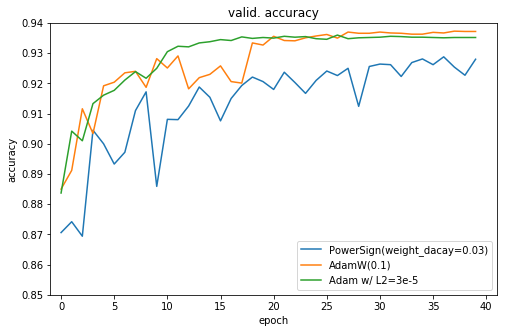

In [49]:
plot_history(hists, attribute='val_acc', loc='lower right')

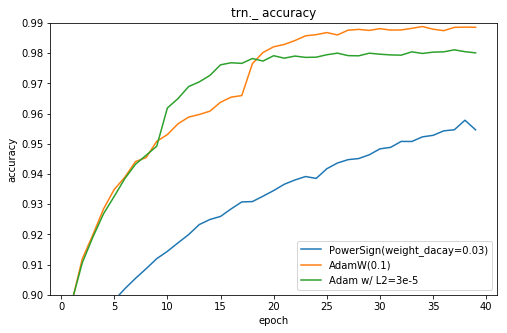

In [50]:
plot_history(hists, attribute='acc', axis=(-1,41,0.9,0.99), loc='lower right')

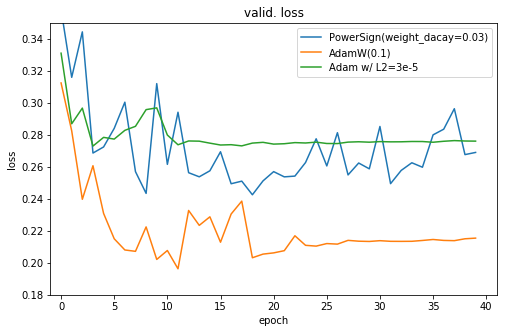

In [54]:
plot_history(hists, attribute='val_loss', axis=(-1,41,0.18,0.35), loc='upper right')

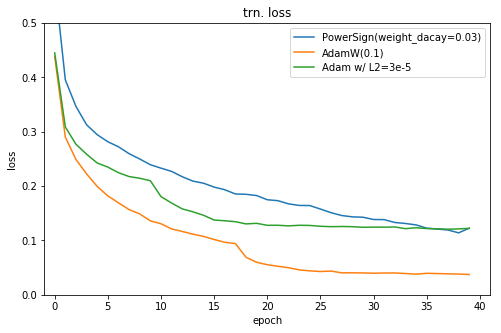

In [55]:
plot_history(hists, attribute='loss', axis=(-1,41,0.00,0.5), loc='upper right')